In [3]:
import pandas as pd
df = pd.read_csv("actual.csv")

Epoch 1/5
305/305 [==============================] - 8s 10ms/step - loss: 0.0099
Epoch 2/5
305/305 [==============================] - 8s 25ms/step - loss: 0.0066
Epoch 3/5
305/305 [==============================] - 6s 19ms/step - loss: 0.0057
Epoch 4/5
305/305 [==============================] - 5s 16ms/step - loss: 0.0052
Epoch 5/5
3/3 [==============================] - 0s 13ms/step


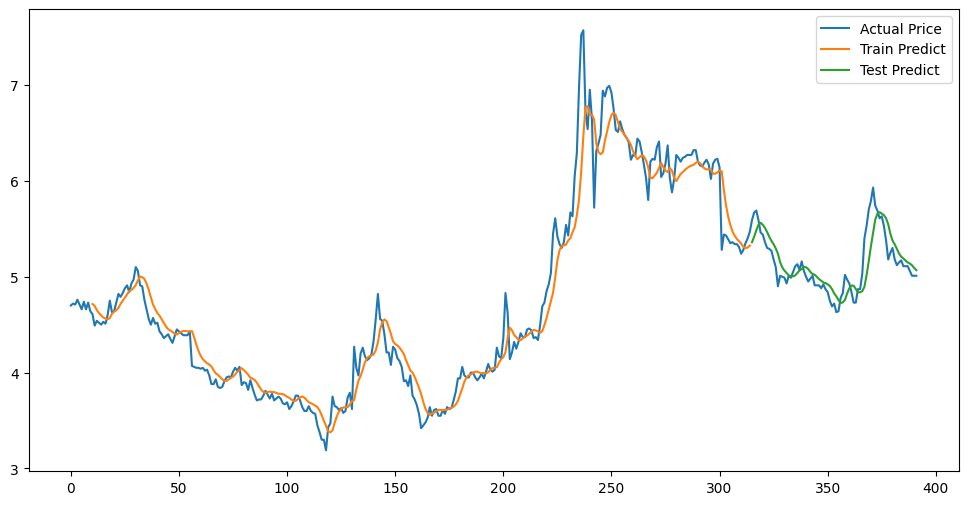

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Assuming df is already loaded
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# We will use the 'Close' prices for LSTM
close_prices = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # Number of previous days to consider for predicting the next day
X, y = create_sequences(scaled_data, time_step)

# Reshape X to be [samples, time steps, features] as required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=5)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions to get back to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Adjust the valid data for plotting
train = close_prices[:train_size + time_step]
valid = np.zeros_like(close_prices)
valid[:train_size + time_step] = np.nan
valid[train_size + time_step:] = test_predict.reshape(-1, 1)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(close_prices, label='Actual Price')
plt.plot(np.arange(time_step, time_step + len(train_predict)), train_predict, label='Train Predict')
plt.plot(valid, label='Test Predict')
plt.legend()
plt.show()
